<a href="https://colab.research.google.com/github/hmlewis-astro/street_network_deep_learning/blob/main/test_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change to GPU runtime

#### Navigate to "Runtime > Change runtime type > GPU > Save"

# Download Kaggle API credentials
#### **Note**: This is a one-time step and you don’t need to generate the credentials every time you download the dataset.
- Navigate to your Kaggle profile
- Click the "Account" tab
- Scroll down to the "API" section
- Click "Create New API Token"; a file named `kaggle.json` will be download which contains your username and API key

# Upload Kaggle API credentials to Google Colab
#### **Note**: Uploaded files will get deleted when this runtime is recycled.
- Upload the `kaggle.json` file that you just downloaded from Kaggle
- Run the following cell

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download balraj98/deepglobe-road-extraction-dataset

100% 3.79G/3.79G [01:14<00:00, 104MB/s] 
100% 3.79G/3.79G [01:14<00:00, 54.6MB/s]


In [2]:
!unzip -q /content/deepglobe-road-extraction-dataset.zip -d /content/deep-globe

In [4]:
!rm -rf /content/deepglobe-road-extraction-dataset.zip

# Import packages and libraries

In [42]:
import os
import glob
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img



In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Get class dictionary

In [7]:
class_dict_path = "/content/deep-globe/class_dict.csv"
class_dict = pd.read_csv(class_dict_path)
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()
class_dict

,name,r,g,b
0,road,255,255,255
1,background,0,0,0


# Get metadata

In [8]:
metadata_path = "/content/deep-globe/metadata.csv"
metadata = pd.read_csv(metadata_path)
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


### Get training/validation data (i.e., images with available road masks)


In [11]:
metadata_train = metadata[metadata['split'] == 'train']
metadata_train = metadata_train.drop('split', axis=1)
metadata_train.head()

,image_id,sat_image_path,mask_path
0,100034,train/100034_sat.jpg,train/100034_mask.png
1,100081,train/100081_sat.jpg,train/100081_mask.png
2,100129,train/100129_sat.jpg,train/100129_mask.png
3,100703,train/100703_sat.jpg,train/100703_mask.png
4,100712,train/100712_sat.jpg,train/100712_mask.png


In [12]:
metadata_train = metadata_train.sample(frac=1).reset_index(drop=True)

In [13]:
metadata_train.shape

(6226, 3)

### Get test data (i.e., images without available road masks)

Combine the datasets defined (by Kaggle) as "validation" and "test", because the "validation" set does not have road masks, so cannot actually be used for validation

In [14]:
metadata_test = metadata[(metadata['split'] == 'valid') | 
                         (metadata['split'] == 'test')]
metadata_test = metadata_test.drop(['split', 'mask_path'], axis=1)
metadata_test.head()

,image_id,sat_image_path
6226,100794,valid/100794_sat.jpg
6227,100905,valid/100905_sat.jpg
6228,102867,valid/102867_sat.jpg
6229,10417,valid/10417_sat.jpg
6230,106553,valid/106553_sat.jpg


In [15]:
metadata_test = metadata_test.sample(frac=1).reset_index(drop=True)

In [16]:
metadata_test.shape

(2344, 2)

In [17]:
data_path = "/content/deep-globe/"


In [18]:
metadata_train["sat_image_path"] = metadata_train["sat_image_path"] \
                                    .apply(lambda x: os.path.join(data_path, x))
metadata_train["mask_path"] = metadata_train["mask_path"] \
                                    .apply(lambda x: os.path.join(data_path, x))


In [19]:
metadata_test["sat_image_path"] = metadata_test["sat_image_path"] \
                                    .apply(lambda x: os.path.join(data_path, x))


In [20]:
metadata_train.head()

,image_id,sat_image_path,mask_path
0,700023,/content/deep-globe/train/700023_sat.jpg,/content/deep-globe/train/700023_mask.png
1,699877,/content/deep-globe/train/699877_sat.jpg,/content/deep-globe/train/699877_mask.png
2,805996,/content/deep-globe/train/805996_sat.jpg,/content/deep-globe/train/805996_mask.png
3,971038,/content/deep-globe/train/971038_sat.jpg,/content/deep-globe/train/971038_mask.png
4,347737,/content/deep-globe/train/347737_sat.jpg,/content/deep-globe/train/347737_mask.png


# Sample satellite images and road masks

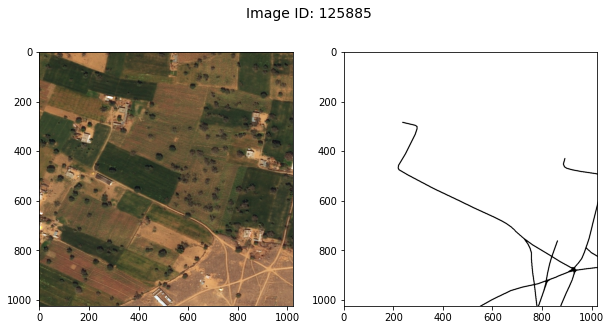

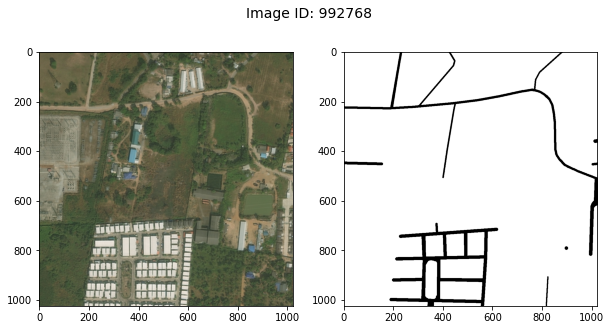

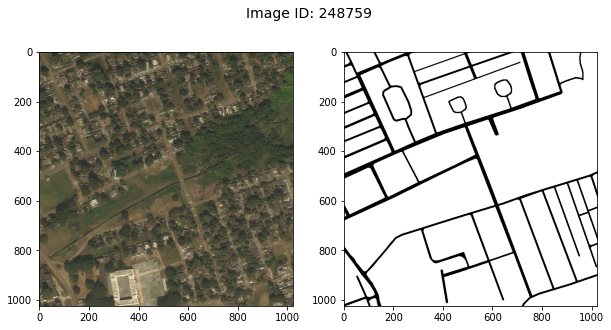

In [23]:
img_idx = np.random.choice(range(len(metadata_train)), size=3)

for i in img_idx:
  sat_img = cv2.cvtColor(cv2.imread(metadata_train['sat_image_path'][i]), 
                         cv2.COLOR_BGR2RGB)
  sat_mask = cv2.cvtColor(cv2.imread(metadata_train['mask_path'][i]), 
                          cv2.COLOR_BGR2RGB)[:,:,0]

  fig, ax = plt.subplots(1, 2, figsize=(10,5))

  fig.suptitle('Image ID: {}'.format(metadata_train['image_id'][i]), 
               fontsize=14)
  ax[0].imshow(sat_img)
  ax[1].imshow(sat_mask, cmap='Greys');

In [25]:
img_dim, img_dim = sat_mask.shape


In [32]:
img_size = (1024, 1024)
num_classes = 2
batch_size = 32

input_img_paths = sorted(metadata_train["sat_image_path"])
target_img_paths = sorted(metadata_train["mask_path"])

print('Number of training/validation samples:', len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print('Satellite image:', input_path, '|', 'Road mask:', target_path)


Number of training/validation samples: 6226
Satellite image: /content/deep-globe/train/100034_sat.jpg | Road mask: /content/deep-globe/train/100034_mask.png
Satellite image: /content/deep-globe/train/100081_sat.jpg | Road mask: /content/deep-globe/train/100081_mask.png
Satellite image: /content/deep-globe/train/100129_sat.jpg | Road mask: /content/deep-globe/train/100129_mask.png
Satellite image: /content/deep-globe/train/100703_sat.jpg | Road mask: /content/deep-globe/train/100703_mask.png
Satellite image: /content/deep-globe/train/100712_sat.jpg | Road mask: /content/deep-globe/train/100712_mask.png
Satellite image: /content/deep-globe/train/100773_sat.jpg | Road mask: /content/deep-globe/train/100773_mask.png
Satellite image: /content/deep-globe/train/100841_sat.jpg | Road mask: /content/deep-globe/train/100841_mask.png
Satellite image: /content/deep-globe/train/100867_sat.jpg | Road mask: /content/deep-globe/train/100867_mask.png
Satellite image: /content/deep-globe/train/100892_sa

# Create Sequence class to load and vectorize batches of data

In [36]:
class SatDatClass(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, 
                           color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 0, 1, 3. 
            # Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


# U-Net Xception-style model

In [39]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", 
                            padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [40]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [41]:
model = get_model(img_size, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [55]:
# Split into training and validation set
val_samples = int(0.2 * len(input_img_paths))
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatDatClass(batch_size, img_size, 
                        train_input_img_paths, train_target_img_paths)
val_gen = SatDatClass(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [56]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.EarlyStopping(patience=8, verbose=1, 
                                           restore_best_weights=True),
             keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, 
                                               verbose=1),
             keras.callbacks.ModelCheckpoint("/content/satellite_segmentation.h5", 
                                             save_best_only=True)]

# Train the model, validate at the end of each epoch
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/5


KeyboardInterrupt: ignored